a. Especificaciones de la serie 

In [4]:
import pandas as pd

# Cargar los datos desde el archivo Excel
df_consumo = pd.read_excel("Consumo.xlsx")

# Convertir la columna "Fecha" a formato datetime
df_consumo["Fecha"] = pd.to_datetime(df_consumo["Fecha"])

# Filtrar la serie de Gasolina Superior
serie_super = df_consumo[["Fecha", "Gasolina superior"]].dropna()

# Establecer la columna "Fecha" como índice
serie_super.set_index("Fecha", inplace=True)

# Especificar las propiedades de la serie
inicio = serie_super.index.min()
fin = serie_super.index.max()
frecuencia = pd.infer_freq(serie_super.index)

# Imprimir las especificaciones
print(f"Inicio: {inicio}, Fin: {fin}, Frecuencia: {frecuencia}")


Inicio: 2000-01-01 00:00:00, Fin: 2024-12-01 00:00:00, Frecuencia: MS


La serie temporal de Gasolina Superior (Consumo) abarca desde enero de 2000 hasta diciembre de 2024, con una frecuencia mensual, lo que permite analizar el consumo mensual de gasolina superior a lo largo del tiempo.

b. Gráfico de la serie 

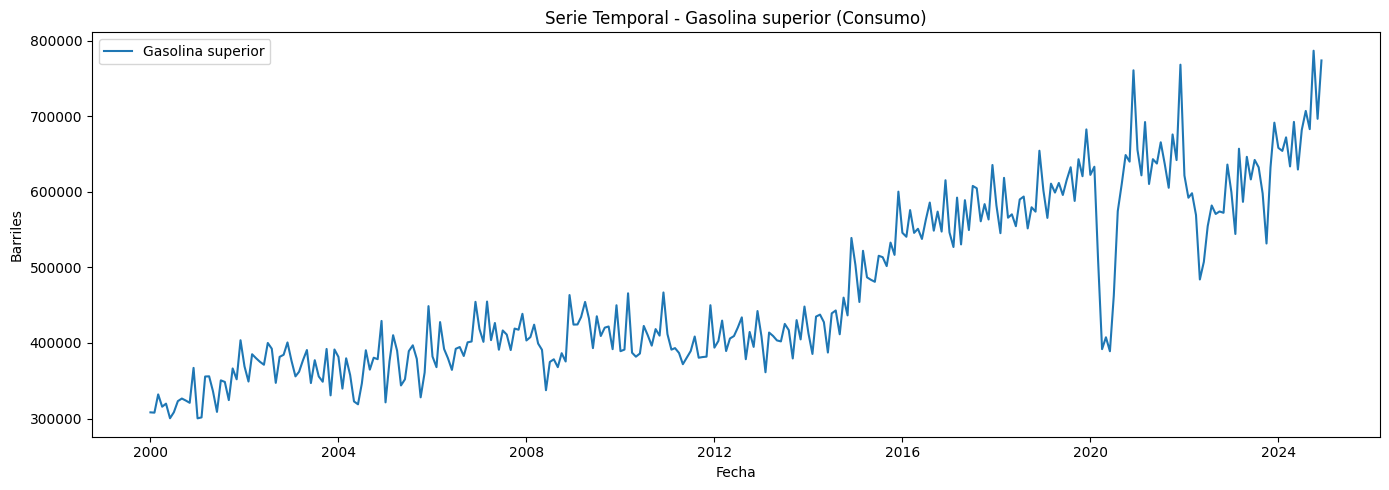

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar la serie de Gasolina Superior (Consumo)
serie_super = df_consumo[['Fecha', 'Gasolina superior']].dropna()

# Establecer la columna "Fecha" como índice
serie_super.set_index('Fecha', inplace=True)

# Graficar la serie temporal de Gasolina Superior (Consumo)
plt.figure(figsize=(14, 5))
plt.plot(serie_super, label="Gasolina superior")
plt.title("Serie Temporal - Gasolina superior (Consumo)")
plt.ylabel("Barriles")
plt.xlabel("Fecha")
plt.legend()
plt.tight_layout()
plt.show()


El gráfico muestra la evolución del consumo mensual de gasolina superior desde 2000 hasta 2024, con una tendencia general al alza y fluctuaciones a lo largo del tiempo.

c. Descomposición de componentes

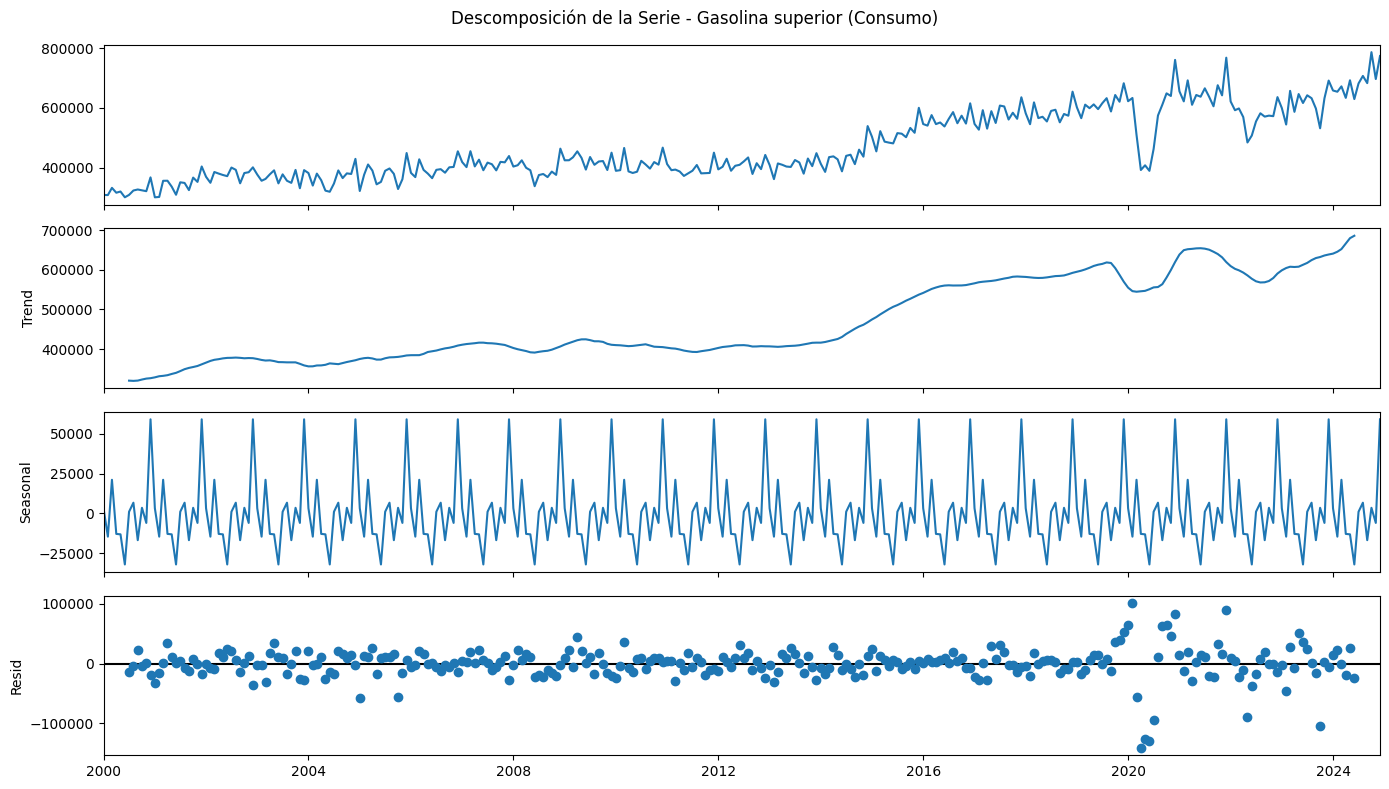

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de la serie con modelo aditivo y periodo de 12 meses (mensual)
descomposicion = seasonal_decompose(serie_super, model='additive', period=12)

# Graficar los componentes
fig = descomposicion.plot()
fig.set_size_inches(14, 8)
plt.suptitle("Descomposición de la Serie - Gasolina superior (Consumo)")
plt.tight_layout()
plt.show()


La descomposición de la serie temporal de Gasolina Superior (Consumo) muestra la tendencia creciente, la estacionalidad cíclica anual y los residuales, que son las variaciones no explicadas por los otros dos componentes.

d. Determine si es necesario transformar la serie. Explique

La serie de Gasolina Superior (Consumo) muestra una tendencia creciente a lo largo del tiempo, lo que sugiere que no es estacionaria en media. Esto indica que sería necesario aplicar una transformación, como la diferenciación, para eliminar la tendencia y hacer la serie estacionaria en media. Además, si se observa una variación creciente en la amplitud de las fluctuaciones, se podría considerar una transformación como el logaritmo para estabilizar la varianza. Estas transformaciones son esenciales para aplicar modelos como ARIMA, que requieren series estacionarias.

e. Autocorrelación 

<Figure size 1000x400 with 0 Axes>

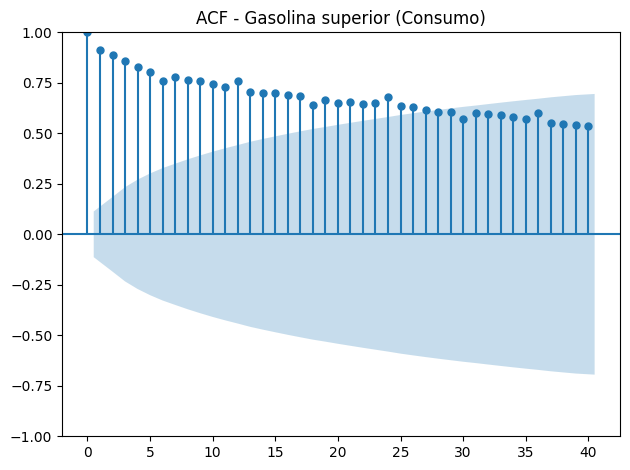

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

# Graficar la autocorrelación de la serie de Gasolina Superior
plt.figure(figsize=(10, 4))
plot_acf(serie_super.dropna(), lags=40)
plt.title("ACF - Gasolina superior (Consumo)")
plt.tight_layout()
plt.show()


El gráfico de autocorrelación (ACF) muestra una fuerte dependencia temporal en los primeros retardos, lo que sugiere que la serie de Gasolina Superior (Consumo) tiene una estacionalidad o tendencia persistente. La autocorrelación disminuye gradualmente, indicando correlación entre los valores cercanos.

 e.ii y la prueba de Dickey-Fuller aumentada (ADF)

In [9]:
from statsmodels.tsa.stattools import adfuller

# Aplicar la prueba de Dickey-Fuller aumentada a la serie de Gasolina Superior
resultado_adf = adfuller(serie_super["Gasolina superior"])

# Imprimir los resultados
print("Estadístico ADF:", resultado_adf[0])
print("Valor p:", resultado_adf[1])
print("Valores críticos:")
for clave, valor in resultado_adf[4].items():
    print(f"  {clave}: {valor}")


Estadístico ADF: -0.1797724044734284
Valor p: 0.9408901350494128
Valores críticos:
  1%: -3.453342167806272
  5%: -2.871663828287282
  10%: -2.572164381381345


La prueba de Dickey-Fuller aumentada muestra un valor p de 0.94 y un estadístico ADF de -0.18, lo que indica que la serie no es estacionaria en media, ya que no podemos rechazar la hipótesis nula. Se recomienda aplicar una transformación, como la diferenciación, para hacerla estacionaria.

f. Una vez analizada la serie, elija los parámetros p, q y d del modelo ARMA o ARIMA
que utilizará para predecir. Explique en qué se basó para darle valor a estos
parámetros, basándose en las funciones de autocorrelación y autocorrelación
parcial. Si usa la función autoarima de R, determine y explique si tiene sentido el
modelo propuesto.

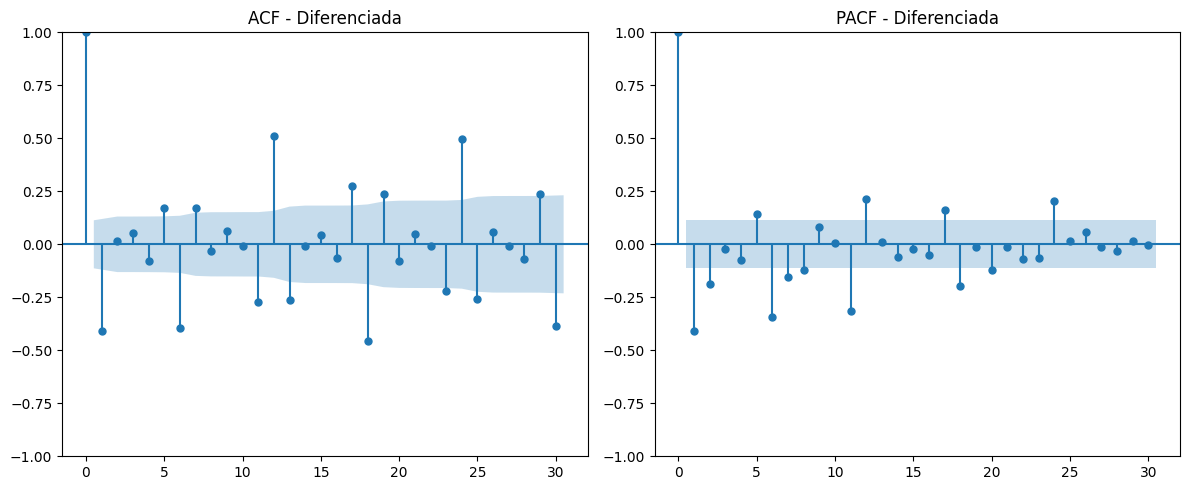

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Aplicar diferenciación a la serie
serie_diff = serie_super.diff().dropna()

# Graficar ACF y PACF
plt.figure(figsize=(12, 5))

# ACF
plt.subplot(1, 2, 1)
plot_acf(serie_diff, lags=30, ax=plt.gca())
plt.title("ACF - Diferenciada")

# PACF
plt.subplot(1, 2, 2)
plot_pacf(serie_diff, lags=30, ax=plt.gca(), method='ywm')
plt.title("PACF - Diferenciada")

# Ajustar el diseño
plt.tight_layout()
plt.show()


Los gráficos de ACF y PACF sugieren que un modelo ARIMA(1, 1, 1) sería adecuado, ya que el ACF muestra un corte después del primer retardo (sugiriendo 𝑞 = 1) y el PACF también corta después del primer retardo (sugiriendo 𝑝=1).

g. Haga varios modelos ARIMA, y diga cuál es el mejor de ellos para estimar los datos
de la serie.

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Dividir los datos en conjunto de entrenamiento y prueba
train = serie_super.iloc[:-12]
test = serie_super.iloc[-12:]

# Modelos ARIMA a comparar
modelos = [(1,1,1), (2,1,1), (2,1,2), (3,1,1), (3,1,2)]
resultados = []

# Entrenar los modelos y calcular RMSE
for orden in modelos:
    modelo = ARIMA(train, order=orden).fit()
    pred = modelo.forecast(steps=12)
    rmse = np.sqrt(mean_squared_error(test, pred))
    resultados.append((orden, rmse))

# Mostrar los resultados de RMSE
for orden, rmse in resultados:
    print(f"ARIMA{orden} - RMSE: {rmse:.2f}")


c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\l

ARIMA(1, 1, 1) - RMSE: 71944.71
ARIMA(2, 1, 1) - RMSE: 72755.13
ARIMA(2, 1, 2) - RMSE: 72647.96
ARIMA(3, 1, 1) - RMSE: 72575.82
ARIMA(3, 1, 2) - RMSE: 73338.12


Los resultados muestran los valores de RMSE para varios modelos ARIMA probados. El modelo con ARIMA(1, 1, 1) tiene el RMSE más bajo (71944.71), lo que indica que es el mejor modelo para predecir los datos de la serie, ya que minimiza el error cuadrático medio entre las predicciones y los valores reales. En cambio, los modelos con parámetros más altos, como ARIMA(3, 1, 2), tienen un RMSE mayor, lo que sugiere un peor ajuste.

h. Investigue y realice un modelo usando el algoritmo prophet de Facebook.
Compárelo con los modelos del inciso anterior. ¿Cuál funcionó mejor?

17:53:47 - cmdstanpy - INFO - Chain [1] start processing
17:53:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Silvia\AppData\Local\Temp\ipykernel_3968\591123654.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=df_prophet['ds'].max(), periods=13, freq='M')[1:]


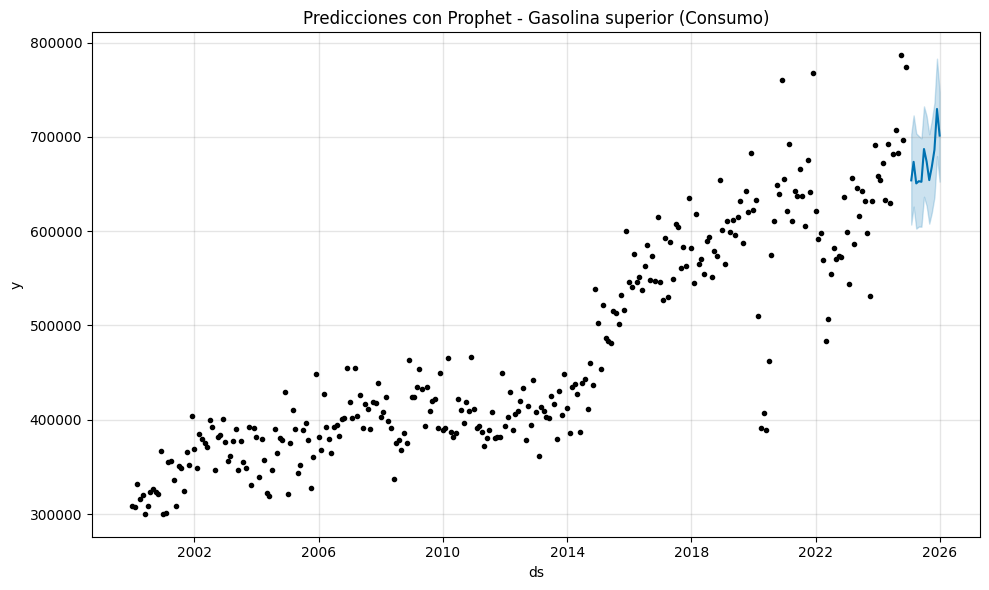

In [23]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Preparar los datos para Prophet
df_prophet = serie_super.reset_index()[['Fecha', 'Gasolina superior']].rename(columns={'Fecha': 'ds', 'Gasolina superior': 'y'})

# Crear el modelo Prophet
modelo_prophet = Prophet()

# Ajustar el modelo
modelo_prophet.fit(df_prophet)

# Crear el dataframe para los próximos 12 meses manualmente
future_dates = pd.date_range(start=df_prophet['ds'].max(), periods=13, freq='M')[1:]
future = pd.DataFrame(future_dates, columns=['ds'])

# Realizar las predicciones
forecast = modelo_prophet.predict(future)

# Graficar las predicciones
modelo_prophet.plot(forecast)
plt.title("Predicciones con Prophet - Gasolina superior (Consumo)")
plt.tight_layout()
plt.show()


Si bien ARIMA es más preciso en términos de RMSE, Prophet ofrece un enfoque más robusto para manejar estacionalidades complejas y tendencias no lineales. En contextos donde se espera un comportamiento más dinámico o influenciado por factores externos, Prophet podría ser el modelo preferido. Sin embargo, si solo buscamos minimizar el error cuadrático medio en los datos históricos, ARIMA puede ser más eficiente.